# E2E (31/32) Forecast Sales Quantities

In [133]:
# usual imports # 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [134]:
# ignore unwanted warnings #
import warnings
warnings.filterwarnings(action='ignore')

In [135]:
# consistent plot size #
from pylab import rcParams
rcParams['figure.figsize']=12,5

In [136]:
from datetime import datetime

In [137]:
# load the datasets #
df_sales = pd.read_csv('/cxldata/datasets/project/sales_historical_sales_value.csv',index_col='time',parse_dates=True)

In [138]:
df_income = pd.read_csv('/cxldata/datasets/project/sales_disposable_personal_income.csv',index_col='time',parse_dates=True)

In [139]:
df_sales.head()

,ID1,ID2,value
time,,,
2010-11-13,1,2,130
2010-11-20,1,2,222
2010-11-27,1,2,166
2010-12-04,1,2,174
2010-12-11,1,2,236


In [140]:
df_income.head()

,value
time,
2009-11-07,10886.9
2009-11-14,10886.9
2009-11-21,10886.9
2009-11-28,10886.9
2009-12-05,10924.7


In [141]:
df_sales.loc['2012-02-25']

,ID1,ID2,value
time,,,
2012-02-25,1,2,284
2012-02-25,2,1,114
2012-02-25,3,1,62
2012-02-25,4,2,194
2012-02-25,5,1,118
2012-02-25,6,1,870
2012-02-25,7,1,294
2012-02-25,8,1,558
2012-02-25,9,1,460


In [142]:
df_sales.index

DatetimeIndex(['2010-11-13', '2010-11-20', '2010-11-27', '2010-12-04',
               '2010-12-11', '2010-12-18', '2010-12-25', '2011-01-01',
               '2011-01-08', '2011-01-15',
               ...
               '2013-10-19', '2013-10-26', '2013-11-09', '2013-11-16',
               '2013-11-23', '2013-11-30', '2013-12-07', '2013-12-14',
               '2013-12-21', '2013-12-28'],
              dtype='datetime64[ns]', name='time', length=2459, freq=None)

In [143]:
# check the date index and infer the freq #
df_income.index

DatetimeIndex(['2009-11-07', '2009-11-14', '2009-11-21', '2009-11-28',
               '2009-12-05', '2009-12-12', '2009-12-19', '2009-12-26',
               '2010-01-02', '2010-01-09',
               ...
               '2013-11-23', '2013-11-30', '2013-12-07', '2013-12-14',
               '2013-12-21', '2013-12-28', '2014-01-04', '2014-01-11',
               '2014-01-18', '2014-01-25'],
              dtype='datetime64[ns]', name='time', length=221, freq=None)

In [144]:
# set the index freq #
df_income.index.freq = 'W-SAT'

In [145]:
# check the datetime index freq after assigning the freq to Weekly Saturday #
df_income.index

DatetimeIndex(['2009-11-07', '2009-11-14', '2009-11-21', '2009-11-28',
               '2009-12-05', '2009-12-12', '2009-12-19', '2009-12-26',
               '2010-01-02', '2010-01-09',
               ...
               '2013-11-23', '2013-11-30', '2013-12-07', '2013-12-14',
               '2013-12-21', '2013-12-28', '2014-01-04', '2014-01-11',
               '2014-01-18', '2014-01-25'],
              dtype='datetime64[ns]', name='time', length=221, freq='W-SAT')

In [146]:
income = df_income.copy()

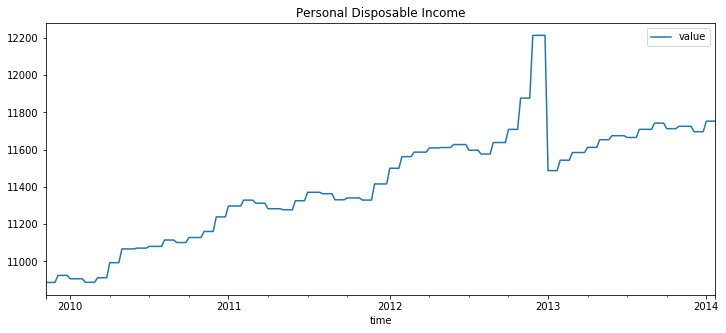

In [147]:
income.plot(legend=True,title='Personal Disposable Income');

In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [149]:
decompose = seasonal_decompose(income['value'],model='additive')

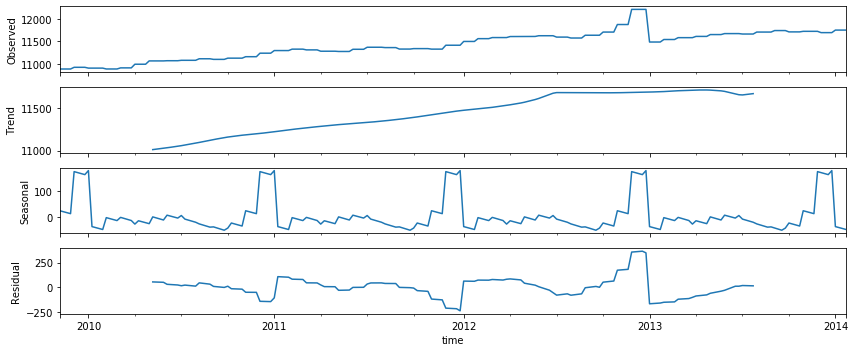

In [150]:
decompose.plot();

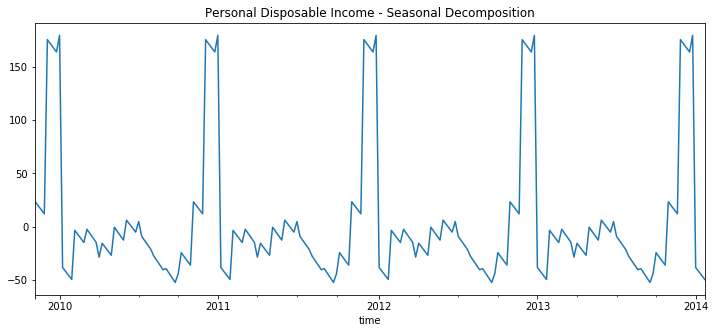

In [151]:
decompose.seasonal.plot(title='Personal Disposable Income - Seasonal Decomposition')

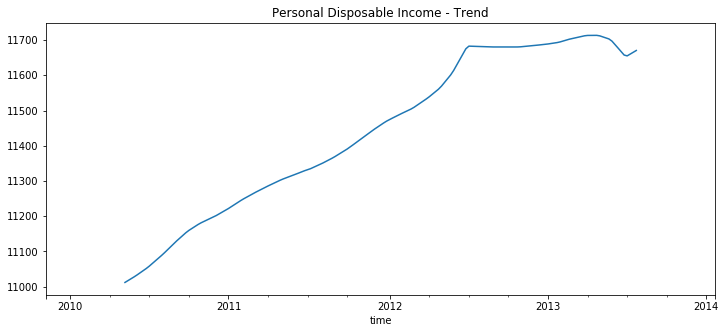

In [152]:
decompose.trend.plot(title='Personal Disposable Income - Trend');

In [153]:
# dickey fuller test to test for stationarity #

def dickey_fuller(series,title='Your Dataset'):
    from statsmodels.tsa.stattools import adfuller
    
    print(f'Augmented Dickey Fuller Test of {title}\n')
    result = adfuller(series.dropna(),autolag='AIC')
    
    df = pd.Series(result[0:4],index=['test-statistics','p-Value','#lags used','#observations'])
    
    print (df.to_string())
    
    for key,value in result[4].items():
        print (f'critical {key} value is {value}')
               
                 
    if result[1] < 0.05:
        print ('There is sufficient evidence against the Null Hypothesis')
        print ('We reject the Null Hypothesis')
        print ('Conclusion: The provided dataset is stationary')
    else:
        print ('There is not sufficient evidence against the Null Hypothesis')
        print ('We fail to reject the Null Hypothesis')
        print ('Conclusion: The provided dataset is non-stationary')

In [154]:
dickey_fuller(income['value'],title = 'Personal Disposable Income')

Augmented Dickey Fuller Test of Personal Disposable Income

test-statistics     -1.575139
p-Value              0.496069
#lags used           5.000000
#observations      215.000000
critical 1% value is -3.461136478222043
critical 5% value is -2.875078880098608
critical 10% value is -2.5739861168199027
There is not sufficient evidence against the Null Hypothesis
We fail to reject the Null Hypothesis
Conclusion: The provided dataset is non-stationary


- As per the Dickey Fuller test , the data set is non stationary 

In [155]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,month_plot,quarter_plot

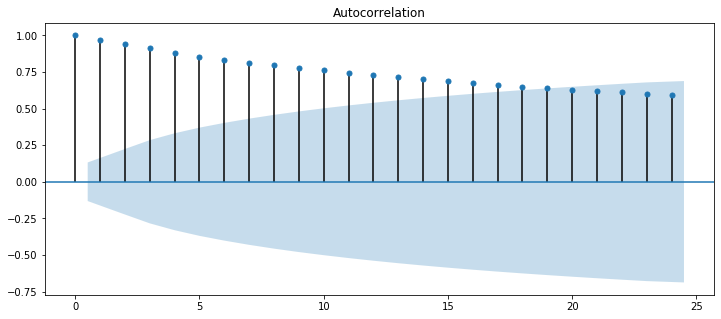

In [156]:
# auto correlation plot #
plot_acf(income['value']);

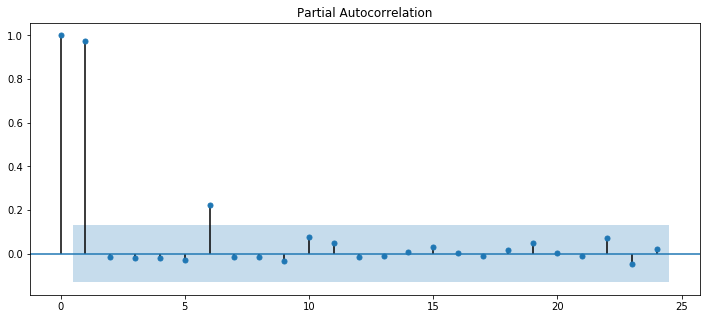

In [157]:
# partial auto correlation plot #
plot_pacf(income['value']);

- ACF decays gradually while PACF cuts off sharply. 
- The autocorrelation pattern can be better explained by adding an AR term than the MA term

In [158]:
# import the AR model
from statsmodels.tsa.ar_model import AR
from pandas.plotting import lag_plot

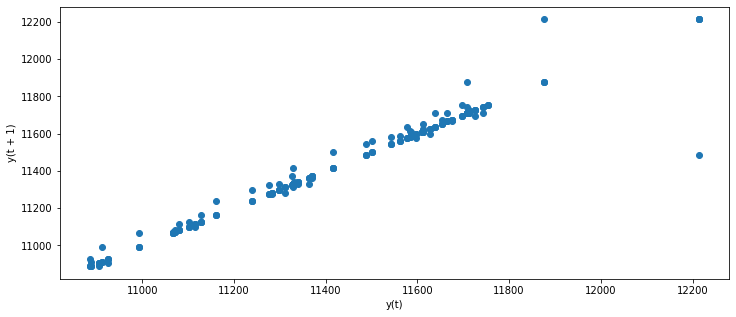

In [159]:
lag_plot(income['value'],lag=1);

- The plot indicates that the dataset is highly auto correlated. Difference of 1 lag should make the
  dataset stationary

In [160]:
income['diff1'] = income['value'].diff()

In [161]:
dickey_fuller(income['diff1'])

Augmented Dickey Fuller Test of Your Dataset

test-statistics   -8.523404e+00
p-Value            1.085282e-13
#lags used         4.000000e+00
#observations      2.150000e+02
critical 1% value is -3.461136478222043
critical 5% value is -2.875078880098608
critical 10% value is -2.5739861168199027
There is sufficient evidence against the Null Hypothesis
We reject the Null Hypothesis
Conclusion: The provided dataset is stationary


- The dataset becomes stationary with first order difference

In [162]:
income.dropna(inplace=True)
model = AR(income['value'])

In [163]:
fitt = model.fit(ic='t-stat')

In [164]:
fitt.k_ar

6

In [165]:
fitt.params

const       255.841284
L1.value      1.001386
L2.value     -0.019711
L3.value     -0.000799
L4.value      0.065309
L5.value     -0.369888
L6.value      0.301726
dtype: float64

- AR order of 6 is returned by the model

In [166]:
decompose1 = seasonal_decompose(income['diff1'],model='additive')

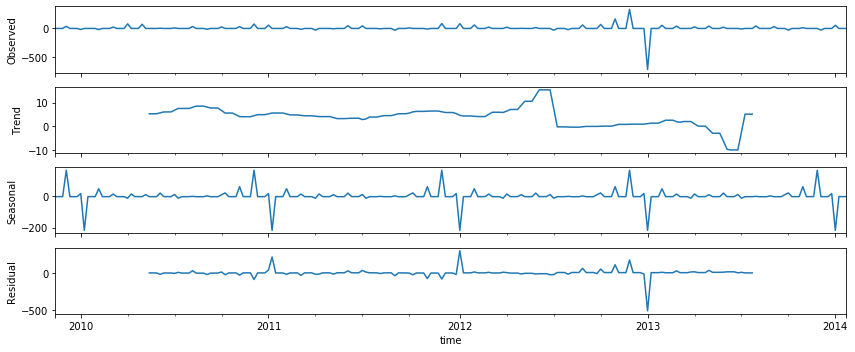

In [167]:
decompose1.plot(); # check for trend and seasonality in the first order difference 

In [168]:
income.head()

,value,diff1
time,,
2009-11-14,10886.9,0.0
2009-11-21,10886.9,0.0
2009-11-28,10886.9,0.0
2009-12-05,10924.7,37.8
2009-12-12,10924.7,0.0


In [169]:
sales = df_sales.copy()

In [170]:
sales.head()

,ID1,ID2,value
time,,,
2010-11-13,1,2,130
2010-11-20,1,2,222
2010-11-27,1,2,166
2010-12-04,1,2,174
2010-12-11,1,2,236


In [171]:
sales.index

DatetimeIndex(['2010-11-13', '2010-11-20', '2010-11-27', '2010-12-04',
               '2010-12-11', '2010-12-18', '2010-12-25', '2011-01-01',
               '2011-01-08', '2011-01-15',
               ...
               '2013-10-19', '2013-10-26', '2013-11-09', '2013-11-16',
               '2013-11-23', '2013-11-30', '2013-12-07', '2013-12-14',
               '2013-12-21', '2013-12-28'],
              dtype='datetime64[ns]', name='time', length=2459, freq=None)

In [172]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2010-11-13 to 2013-12-28
Data columns (total 3 columns):
ID1      2459 non-null int64
ID2      2459 non-null int64
value    2459 non-null int64
dtypes: int64(3)
memory usage: 76.8 KB


In [173]:
sales.columns = ['StoreID','ProductID','value']

In [174]:
sales.head()

,StoreID,ProductID,value
time,,,
2010-11-13,1,2,130
2010-11-20,1,2,222
2010-11-27,1,2,166
2010-12-04,1,2,174
2010-12-11,1,2,236


In [175]:
sales['StoreID'].value_counts()

15    164
13    164
11    164
9     164
7     164
5     164
3     164
14    164
12    164
10    164
8     164
6     164
4     164
2     164
1     163
Name: StoreID, dtype: int64

In [176]:
sales['ProductID'].value_counts().sort_values(ascending=False)

1    2132
2     327
Name: ProductID, dtype: int64

In [177]:
sales.reset_index()

,time,StoreID,ProductID,value
0,2010-11-13,1,2,130
1,2010-11-20,1,2,222
2,2010-11-27,1,2,166
3,2010-12-04,1,2,174
4,2010-12-11,1,2,236
...,...,...,...,...
2454,2013-11-30,15,1,140
2455,2013-12-07,15,1,186
2456,2013-12-14,15,1,184
2457,2013-12-21,15,1,220


In [178]:
tsales = sales.groupby(['time','StoreID','ProductID'],observed=True)['value'].sum()

In [179]:
tsales

time        StoreID  ProductID
2010-11-06  2        1             144
            3        1              60
            4        2             440
            5        1             128
            6        1             302
                                  ... 
2013-12-28  11       1             182
            12       1            1470
            13       1            1248
            14       1             694
            15       1             212
Name: value, Length: 2459, dtype: int64

In [180]:
frame = pd.DataFrame(tsales)

In [181]:
frame

value
time       StoreID ProductID       
2010-11-06 2       1            144
           3       1             60
           4       2            440
           5       1            128
           6       1            302
...                             ...
2013-12-28 11      1            182
           12      1           1470
           13      1           1248
           14      1            694
           15      1            212

[2459 rows x 1 columns]

In [182]:
frame.index

MultiIndex([('2010-11-06',  2, 1),
            ('2010-11-06',  3, 1),
            ('2010-11-06',  4, 2),
            ('2010-11-06',  5, 1),
            ('2010-11-06',  6, 1),
            ('2010-11-06',  7, 1),
            ('2010-11-06',  8, 1),
            ('2010-11-06',  9, 1),
            ('2010-11-06', 10, 1),
            ('2010-11-06', 11, 1),
            ...
            ('2013-12-28',  6, 1),
            ('2013-12-28',  7, 1),
            ('2013-12-28',  8, 1),
            ('2013-12-28',  9, 1),
            ('2013-12-28', 10, 1),
            ('2013-12-28', 11, 1),
            ('2013-12-28', 12, 1),
            ('2013-12-28', 13, 1),
            ('2013-12-28', 14, 1),
            ('2013-12-28', 15, 1)],
           names=['time', 'StoreID', 'ProductID'], length=2459)

In [183]:
frame.reset_index(inplace=True)

In [184]:
pincome = income.copy()

In [185]:
pincome.head()

,value,diff1
time,,
2009-11-14,10886.9,0.0
2009-11-21,10886.9,0.0
2009-11-28,10886.9,0.0
2009-12-05,10924.7,37.8
2009-12-12,10924.7,0.0


In [186]:
pincome.reset_index(inplace=True)

In [187]:
pincome.drop('diff1',inplace=True,axis=1)

In [188]:
pincome.head()

,time,value
0,2009-11-14,10886.9
1,2009-11-21,10886.9
2,2009-11-28,10886.9
3,2009-12-05,10924.7
4,2009-12-12,10924.7


In [189]:
frame.columns

Index(['time', 'StoreID', 'ProductID', 'value'], dtype='object')

In [190]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459 entries, 0 to 2458
Data columns (total 4 columns):
time         2459 non-null datetime64[ns]
StoreID      2459 non-null int64
ProductID    2459 non-null int64
value        2459 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 77.0 KB


In [191]:
pincome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
time     220 non-null datetime64[ns]
value    220 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.6 KB


In [192]:
pincome['value'] = pincome['value'].astype(float)

In [193]:
pincome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
time     220 non-null datetime64[ns]
value    220 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.6 KB


In [194]:
pincome.columns

Index(['time', 'value'], dtype='object')

In [195]:
frame.columns

Index(['time', 'StoreID', 'ProductID', 'value'], dtype='object')

In [196]:
pincome.columns = ['time', 'income']

In [197]:
pincome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 2 columns):
time      220 non-null datetime64[ns]
income    220 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.6 KB


In [198]:
frame.head()

,time,StoreID,ProductID,value
0,2010-11-06,2,1,144
1,2010-11-06,3,1,60
2,2010-11-06,4,2,440
3,2010-11-06,5,1,128
4,2010-11-06,6,1,302


In [199]:
# set the date as the index to later join with the income dataframe #
frame.set_index('time',inplace=True)

In [200]:
frame.head()

,StoreID,ProductID,value
time,,,
2010-11-06,2,1,144
2010-11-06,3,1,60
2010-11-06,4,2,440
2010-11-06,5,1,128
2010-11-06,6,1,302


In [201]:
pincome.head()

,time,income
0,2009-11-14,10886.9
1,2009-11-21,10886.9
2,2009-11-28,10886.9
3,2009-12-05,10924.7
4,2009-12-12,10924.7


In [202]:
# set the date as the index to later join with the income dataframe #
pincome.set_index('time',inplace=True)

In [203]:
pincome.head()

,income
time,
2009-11-14,10886.9
2009-11-21,10886.9
2009-11-28,10886.9
2009-12-05,10924.7
2009-12-12,10924.7


In [204]:
# join the sales and the personal disposable income dataset #
df = frame.join(pincome)

In [205]:
# create a copy of the merged dataset #
qsales = df.copy()

In [206]:
qsales.head()

,StoreID,ProductID,value,income
time,,,,
2010-11-06,2,1,144,11160.8
2010-11-06,3,1,60,11160.8
2010-11-06,4,2,440,11160.8
2010-11-06,5,1,128,11160.8
2010-11-06,6,1,302,11160.8


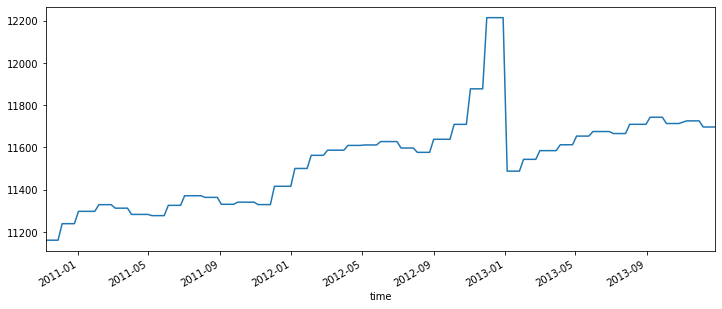

In [207]:
# plot and check affect due to merging the datasets #
qsales['income'].plot()

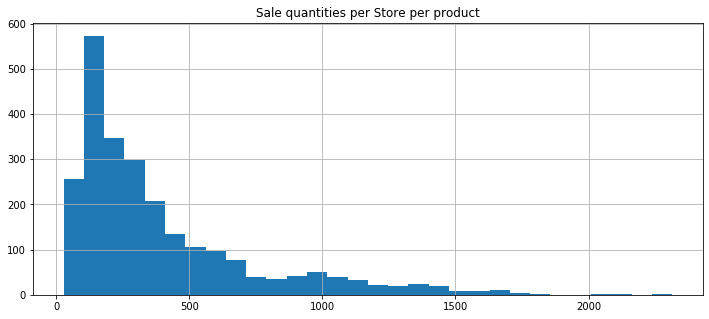

In [208]:
plt.hist(qsales['value'],bins=30)
plt.grid()
plt.title('Sale quantities per Store per product');

- The sale quantity is right skewed and does not follow a normal distribution 
- Transformation of the sale quantities can be done and then the distribution can be rechecked

In [209]:
# check for sale quantities less than 20 #
len(qsales[qsales['value'] < 20])

0

- There are no dates when the sale quantity was less than 20 

In [210]:
import math

In [211]:
qsales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2010-11-06 to 2013-12-28
Data columns (total 4 columns):
StoreID      2459 non-null int64
ProductID    2459 non-null int64
value        2459 non-null int64
income       2459 non-null float64
dtypes: float64(1), int64(3)
memory usage: 96.1 KB


In [212]:
qsales['value'] = qsales['value'].astype(float)

In [213]:
qsales.head()

,StoreID,ProductID,value,income
time,,,,
2010-11-06,2,1,144.0,11160.8
2010-11-06,3,1,60.0,11160.8
2010-11-06,4,2,440.0,11160.8
2010-11-06,5,1,128.0,11160.8
2010-11-06,6,1,302.0,11160.8


In [214]:
# Applying the log transformation , +1 to prevent -inf for accidental log on 0 or null values #
qsales['logvalue'] = np.log(qsales['value']+1)

In [215]:
qsales['logvalue'].describe()

count    2459.000000
mean        5.634582
std         0.825383
min         3.367296
25%         5.003946
50%         5.609472
75%         6.226535
max         7.747165
Name: logvalue, dtype: float64

Text(0.5, 0, 'Sale quantities on logarithmic scale')

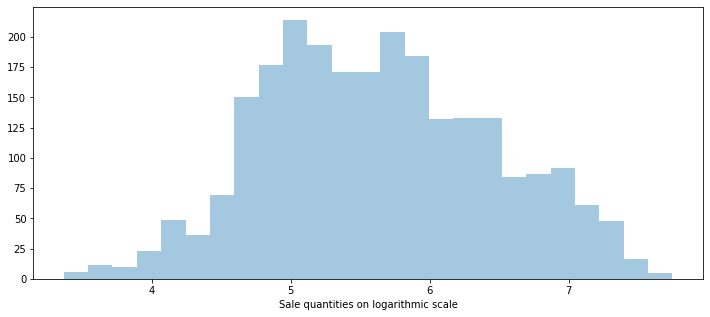

In [216]:
sns.distplot(qsales['logvalue'],kde=False);
plt.xlabel('Sale quantities on logarithmic scale')

In [217]:
qsales.index.unique()

DatetimeIndex(['2010-11-06', '2010-11-13', '2010-11-20', '2010-11-27',
               '2010-12-04', '2010-12-11', '2010-12-18', '2010-12-25',
               '2011-01-01', '2011-01-08',
               ...
               '2013-10-19', '2013-10-26', '2013-11-09', '2013-11-16',
               '2013-11-23', '2013-11-30', '2013-12-07', '2013-12-14',
               '2013-12-21', '2013-12-28'],
              dtype='datetime64[ns]', name='time', length=164, freq=None)

In [218]:
import holidays
from datetime import date

In [219]:
holiday = [] 

for hol in holidays.UnitedStates(years = [2010,2011,2012,2013]).keys():
    holiday.append(hol)

In [220]:
# print the US holidays in 2014 to 2016 #
for hol in holidays.UnitedStates(years = [2010,2011,2012,2013]).items():
    print (hol)

(datetime.date(2010, 1, 1), "New Year's Day")
(datetime.date(2010, 12, 31), "New Year's Day (Observed)")
(datetime.date(2010, 1, 18), 'Martin Luther King, Jr. Day')
(datetime.date(2010, 2, 15), "Washington's Birthday")
(datetime.date(2010, 5, 31), 'Memorial Day')
(datetime.date(2010, 7, 4), 'Independence Day')
(datetime.date(2010, 7, 5), 'Independence Day (Observed)')
(datetime.date(2010, 9, 6), 'Labor Day')
(datetime.date(2010, 10, 11), 'Columbus Day')
(datetime.date(2010, 11, 11), 'Veterans Day')
(datetime.date(2010, 11, 25), 'Thanksgiving')
(datetime.date(2010, 12, 25), 'Christmas Day')
(datetime.date(2010, 12, 24), 'Christmas Day (Observed)')
(datetime.date(2011, 1, 1), "New Year's Day")
(datetime.date(2011, 1, 17), 'Martin Luther King, Jr. Day')
(datetime.date(2011, 2, 21), "Washington's Birthday")
(datetime.date(2011, 5, 30), 'Memorial Day')
(datetime.date(2011, 7, 4), 'Independence Day')
(datetime.date(2011, 9, 5), 'Labor Day')
(datetime.date(2011, 10, 10), 'Columbus Day')
(date

### Add Holidays
- 1 if the date is a holiday 
- 0 if the date is Not a holiday

In [221]:
# check each row date if it is in the holiday list of 2014 to 2016 #
h = []

for i in range(len(qsales)):
    if (qsales.index[i] in holiday):
        h.append(1)
    else:
        h.append(0)

In [222]:
qsales['holiday'] = h

In [223]:
qsales.head()

,StoreID,ProductID,value,income,logvalue,holiday
time,,,,,,
2010-11-06,2,1,144.0,11160.8,4.976734,0
2010-11-06,3,1,60.0,11160.8,4.110874,0
2010-11-06,4,2,440.0,11160.8,6.089045,0
2010-11-06,5,1,128.0,11160.8,4.859812,0
2010-11-06,6,1,302.0,11160.8,5.713733,0


### Date Features

In [224]:
# weekday #
wkday = []
for i in range(len(sales)):
    wkday.append(qsales.index[i].weekday())   
    
# year #
yr = []
for i in range(len(sales)):
    yr.append(qsales.index[i].year)   
    
# month #
mon = []
for i in range(len(sales)):
    mon.append(qsales.index[i].month)  

### Weekend Features

In [225]:
# add the weekend column, day value of 5 is Saturday and 6 is for Sunday #
def weekend(day):
    if day == 5 or day == 6:
        return 1
    else:
        return 0

In [226]:
qsales['month'] = mon
qsales['day'] = wkday
qsales['year'] = yr

In [227]:
qsales['weekend'] = qsales['day'].apply(weekend)

In [228]:
qsales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2010-11-06 to 2013-12-28
Data columns (total 10 columns):
StoreID      2459 non-null int64
ProductID    2459 non-null int64
value        2459 non-null float64
income       2459 non-null float64
logvalue     2459 non-null float64
holiday      2459 non-null int64
month        2459 non-null int64
day          2459 non-null int64
year         2459 non-null int64
weekend      2459 non-null int64
dtypes: float64(3), int64(7)
memory usage: 291.3 KB


### Season Features

In [229]:
# first order difference of the logvalue #
qsales['logvalue_Diff1'] = qsales['logvalue'].diff()

In [230]:
# second order difference of the logvalue #
qsales['logvalue_Diff2'] = qsales['logvalue_Diff1'].diff()

In [231]:
# add the previous day sale figure of each individual product of the store  #
qsales['logvalue_Prev1'] = qsales.groupby(['StoreID','ProductID'])['logvalue'].shift()

In [232]:
# add the previous day sale figure of each individual product of the store  #
qsales['logvalue_Prev2'] = qsales.groupby(['StoreID','ProductID'])['logvalue'].shift(periods=2)

In [233]:
qsales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2010-11-06 to 2013-12-28
Data columns (total 14 columns):
StoreID           2459 non-null int64
ProductID         2459 non-null int64
value             2459 non-null float64
income            2459 non-null float64
logvalue          2459 non-null float64
holiday           2459 non-null int64
month             2459 non-null int64
day               2459 non-null int64
year              2459 non-null int64
weekend           2459 non-null int64
logvalue_Diff1    2458 non-null float64
logvalue_Diff2    2457 non-null float64
logvalue_Prev1    2444 non-null float64
logvalue_Prev2    2429 non-null float64
dtypes: float64(7), int64(7)
memory usage: 368.2 KB


In [265]:
# add the lag of the personal disposable income based on AR model #
# adding this column is purely optional ,model predictions are not affected due to this column #
qsales['income_lag'] = qsales.groupby(['StoreID','ProductID'])['income'].shift(periods=6)

In [235]:
qsales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2010-11-06 to 2013-12-28
Data columns (total 15 columns):
StoreID           2459 non-null int64
ProductID         2459 non-null int64
value             2459 non-null float64
income            2459 non-null float64
logvalue          2459 non-null float64
holiday           2459 non-null int64
month             2459 non-null int64
day               2459 non-null int64
year              2459 non-null int64
weekend           2459 non-null int64
logvalue_Diff1    2458 non-null float64
logvalue_Diff2    2457 non-null float64
logvalue_Prev1    2444 non-null float64
logvalue_Prev2    2429 non-null float64
income_lag        2369 non-null float64
dtypes: float64(8), int64(7)
memory usage: 387.4 KB


In [236]:
qsales.head()

,StoreID,ProductID,value,income,logvalue,holiday,month,day,year,weekend,logvalue_Diff1,logvalue_Diff2,logvalue_Prev1,logvalue_Prev2,income_lag
time,,,,,,,,,,,,,,,
2010-11-06,2,1,144.0,11160.8,4.976734,0,11,5,2010,1,NaN,NaN,NaN,NaN,NaN
2010-11-06,3,1,60.0,11160.8,4.110874,0,11,5,2010,1,-0.865860,NaN,NaN,NaN,NaN
2010-11-06,4,2,440.0,11160.8,6.089045,0,11,5,2010,1,1.978171,2.844031,NaN,NaN,NaN
2010-11-06,5,1,128.0,11160.8,4.859812,0,11,5,2010,1,-1.229232,-3.207403,NaN,NaN,NaN
2010-11-06,6,1,302.0,11160.8,5.713733,0,11,5,2010,1,0.853920,2.083153,NaN,NaN,NaN


In [237]:
# change the datatype of ProductID to string #
qsales['ProductID'] =  qsales['ProductID'].astype('str')

In [238]:
# change the datatype of StoreID to string #
qsales['StoreID'] =  qsales['StoreID'].astype('str')

In [239]:
qsales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2010-11-06 to 2013-12-28
Data columns (total 15 columns):
StoreID           2459 non-null object
ProductID         2459 non-null object
value             2459 non-null float64
income            2459 non-null float64
logvalue          2459 non-null float64
holiday           2459 non-null int64
month             2459 non-null int64
day               2459 non-null int64
year              2459 non-null int64
weekend           2459 non-null int64
logvalue_Diff1    2458 non-null float64
logvalue_Diff2    2457 non-null float64
logvalue_Prev1    2444 non-null float64
logvalue_Prev2    2429 non-null float64
income_lag        2369 non-null float64
dtypes: float64(8), int64(5), object(2)
memory usage: 387.4+ KB


In [240]:
product_id = pd.get_dummies(qsales['ProductID'],drop_first=True)
store_id = pd.get_dummies(qsales['StoreID'],drop_first=True)

In [241]:
qsales_encoded = pd.concat([qsales,store_id,product_id],ignore_index=False,axis=1)

In [242]:
qsales_encoded.head()

,StoreID,ProductID,value,income,logvalue,holiday,month,day,year,weekend,...,15,2,3,4,5,6,7,8,9,2
time,,,,,,,,,,,,,,,,,,,,,
2010-11-06,2,1,144.0,11160.8,4.976734,0,11,5,2010,1,...,0,1,0,0,0,0,0,0,0,0
2010-11-06,3,1,60.0,11160.8,4.110874,0,11,5,2010,1,...,0,0,1,0,0,0,0,0,0,0
2010-11-06,4,2,440.0,11160.8,6.089045,0,11,5,2010,1,...,0,0,0,1,0,0,0,0,0,1
2010-11-06,5,1,128.0,11160.8,4.859812,0,11,5,2010,1,...,0,0,0,0,1,0,0,0,0,0
2010-11-06,6,1,302.0,11160.8,5.713733,0,11,5,2010,1,...,0,0,0,0,0,1,0,0,0,0


In [243]:
qsales_encoded.columns

Index(['StoreID', 'ProductID', 'value', 'income', 'logvalue', 'holiday',
       'month', 'day', 'year', 'weekend', 'logvalue_Diff1', 'logvalue_Diff2',
       'logvalue_Prev1', 'logvalue_Prev2', 'income_lag', '10', '11', '12',
       '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9', '2'],
      dtype='object')

In [244]:
#qsales_encoded.drop(['StoreID','ProductID'],axis=1,inplace=True)

In [245]:
len(qsales_encoded)

2459

## Train test split 

In [246]:
qsales_encoded.dropna(inplace=True)

In [247]:
len(qsales_encoded[qsales_encoded['year'] == 2013])

765

In [248]:
len(qsales_encoded[qsales_encoded['year'] != 2013])

1604

In [249]:
for_training = qsales_encoded.iloc[:1604]
for_testing = qsales_encoded.iloc[1604:]

In [250]:
X_train = for_training.drop(['value','logvalue','StoreID','ProductID'],axis=1)
y_train = for_training['logvalue']

X_test = for_testing.drop(['value','logvalue','StoreID','ProductID'],axis=1)
y_test = for_testing[['logvalue','StoreID','ProductID']]

## Train the Model and Predict Sale Quantities 

In [251]:
# import the ensemble models #
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from statsmodels.tools.eval_measures import mse,rmse

In [252]:
rfmodel = RandomForestRegressor(n_estimators=100,random_state=101)

In [253]:
rfmodel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

In [254]:
rf_predictions = rfmodel.predict(X_test)

In [255]:
RF_RMSE = rmse(y_test['logvalue'],rf_predictions)
print(f'RMSE Random Forest Model = {RF_RMSE:.5f}')

RMSE Random Forest Model = 0.17762


In [256]:
gbmodel = GradientBoostingRegressor(n_estimators=100,random_state=101)

In [257]:
gbmodel.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=101, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [258]:
gb_predictions = gbmodel.predict(X_test)

In [259]:
GB_RMSE = rmse(y_test['logvalue'],gb_predictions)
print(f'RMSE Gradient Boosting Model = {GB_RMSE:.5f}')

RMSE Gradient Boosting Model = 0.17379


In [260]:
y_test['logvalue'].describe()

count    765.000000
mean       5.636280
std        0.807299
min        3.367296
25%        5.043425
50%        5.594711
75%        6.333280
max        7.359468
Name: logvalue, dtype: float64

## Cross Validation

In [261]:
from sklearn.model_selection import cross_val_score

In [262]:
gb_scores = cross_val_score(gbmodel, X_train, y_train, cv=10)
gb_scores.mean()

0.9561093598940056

## Conclusion

Against the log transformed sales quantities 

- RMSE using Random Forest Model = 0.17762
- RMSE using Gradient Boost Model = 0.17379

Cross Validation score (RMSE) using the Gradient Boosting model =  0.95610

## Create Comparison Table

In [263]:
# create a dataframe of actual values vs the predicted values #

qsales_compare = pd.DataFrame({'StoreID':y_test['StoreID'],'ProductID':y_test['ProductID'],'SaleValues(log)':y_test['logvalue'],'Model Predictions':gb_predictions})

In [264]:
qsales_compare

,StoreID,ProductID,SaleValues(log),Model Predictions
time,,,,
2013-01-05,1,2,5.313206,5.123745
2013-01-05,2,1,5.093750,5.105931
2013-01-05,3,1,3.610918,3.579991
2013-01-05,4,2,5.659482,5.779354
2013-01-05,5,1,4.634729,4.693193
...,...,...,...,...
2013-12-28,11,1,5.209486,5.134978
2013-12-28,12,1,7.293698,7.217706
2013-12-28,13,1,7.130099,7.014239
